# Panini Monte Carlo Simulation

# Libraries

In [80]:
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks", color_codes=True)
sns.set()

In [2]:
# Properties
n_stickers = 678
cost_per_packs = 1.1
pack_size = 5

## Album

In [63]:
def create_pack(n_stickers, pack_size):
    '''
    Creates a sticker pack that contains n stickers defined by the pack size.
    The stickers are distributed uniformly
    
    Parameters
    ----------
    n_stickers : int
        Number of stickers in the album
    pack_size : int
        Size of a pack of stickers
    
    Returns
    --------
    Numpy array of pack_size stickers.

    '''
    rng = np.random.default_rng()
    return(rng.integers(low=0, high=n_stickers, size=pack_size))

def buy_pack(album, n_stickers, pack_size):
    '''
    Simulates the buying process of on sticker pack.
    
    Creates a new sticker pack. The stickers that are contained inside this pack
    are then added to the album. The sticker number is the ID in the album. Thus, 1 is added
    to the album array at the index i=sticker_number.
    
    Parameters
    ----------
    album : np.array of size n_stickers
        The value at index i determines the amount of stickers with this id are collected.
    n_stickers : int
        Number of stickers in the album
    pack_size : int
        Size of a pack of stickers
        
    Returns
    -------
    album : np.array of size n_stickers
    
    '''
    
    new_stickers = create_pack(n_stickers, pack_size)
    for i in new_stickers:
        album[i] += 1
    
    return album

def fill_album(album, n_stickers, pack_size):
    '''
    Buys stickers until the album is full.
    
    Parameters
    ----------
    album : np.array of size n_stickers
        The value at index i determines the amount of stickers with this id are collected.
    n_stickers : int
        Number of stickers in the album
    pack_size : int
        Size of a pack of stickers
        
    Returns
    -------
    album : np.array of size n_stickers
    num_packs_buy : int
        The amount of packst that had to be bought until the album was complete
    '''
    
    num_packs_buy = 0
    
    # Check if album still contains zeros
    # if not -> buy new pack
    # if yes, stop
    while (album==0).any():
        album = buy_pack(album, n_stickers, pack_size) 
        num_packs_buy += 1
    
    return album, num_packs_buy
    
    
def run_mc_simulation(n_simulations, n_stickers, pack_size):
    '''
    '''
    
    num_packs_fill_album = []
    albums = []
    for i in range(n_simulations):
        if i%1000 == 0: print('Simulation Number: {}'.format(i))
        album = np.zeros(n_stickers)
        album, num_packs_buy = fill_album(album, n_stickers, pack_size)
        num_packs_fill_album.append(num_packs_buy)
        albums.append(album)
        
    return albums, num_packs_fill_album

In [4]:
album = np.zeros(n_stickers)
album, num_packs_buy = fill_album(album, n_stickers, pack_size)
print("Number of packs to fill the album: {}".format(num_packs_buy))

Number of packs to fill the album: 837


In [64]:
albums, num_packs_fill_album = run_mc_simulation(10000, n_stickers, pack_size)

Simulatoin Number: 0
Simulatoin Number: 1000
Simulatoin Number: 2000
Simulatoin Number: 3000
Simulatoin Number: 4000
Simulatoin Number: 5000
Simulatoin Number: 6000
Simulatoin Number: 7000
Simulatoin Number: 8000
Simulatoin Number: 9000


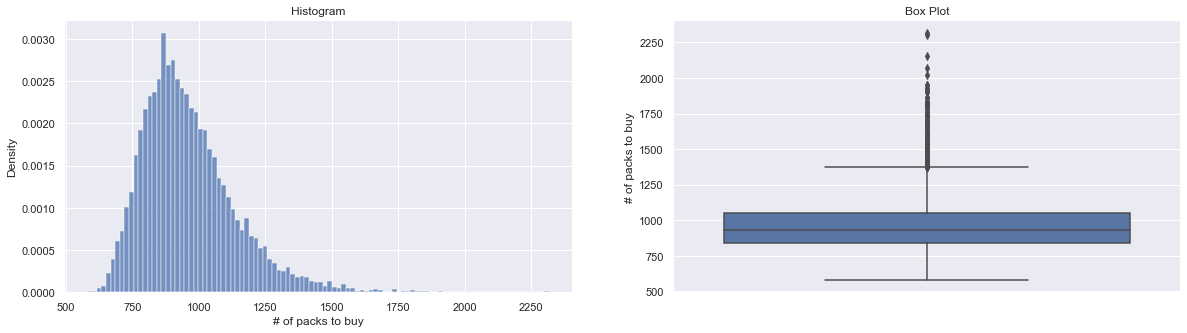

In [163]:
fig, axes = plt.subplots(1, 2, figsize=(20,5))
sns.histplot(ax=axes[0], x=num_packs_fill_album,  bins='sqrt', stat='density');
axes[0].set(ylabel='Density', xlabel='# of packs to buy');
axes[0].set_title('Histogram')
#sns.violinplot(ax=axes[1], y=num_packs_fill_album);
#axes[1].set_title('Violin Plot')
#axes[1].set(ylabel='# of packs to buy');
sns.boxplot(ax=axes[1], y=num_packs_fill_album);
axes[1].set_title('Box Plot')
axes[1].set(ylabel='# of packs to buy');

fig.savefig('no_of_packs')

In [159]:
print('The mean number of packs one has to buy to fill the complete album is: {}'.format(np.mean(num_packs_fill_album)))
print('With a chance of 10%, you need less than {} packs to fill the album '.format(np.percentile(num_packs_fill_album, 10)))
print('With a chance of 10%, you need more than {} packs to fill the album '.format(np.percentile(num_packs_fill_album, 90)))


The mean number of packs one has to buy to fill the complete album is: 962.926
With a chance of 10%, you need less than 770.0 packs to fill the album 
With a chance of 10%, you need more than 1193.0 packs to fill the album 


## Evaluate the duplicates

In [143]:
duplicates = np.zeros(40) 
amount_of_duplicates = []
for album in albums:  
    amount_of_duplicates.append(np.sum(album) - n_stickers) 
    counts = np.bincount(np.int64(album))
    len_counts = len(counts)
    duplicates[0:len_counts] = duplicates[0:len_counts] + counts

In [171]:
print(np.median(amount_of_duplicates))
print('Theoretical amount of duplicates: {}'.format(np.mean(num_packs_fill_album)*pack_size - n_stickers))

print('With a chance of 10%, you will have less than than {} duplicates when completing the album '.format(np.percentile(amount_of_duplicates, 80)))
print('With a chance of 10%, you will have more than than {} duplicates when completing the album '.format(np.percentile(amount_of_duplicates, 90)))


3987.0
Theoretical amount of duplicates: 4136.63
With a chance of 10%, you will have less than than 4762.0 duplicates when completing the album 
With a chance of 10%, you will have more than than 5287.0 duplicates when completing the album 


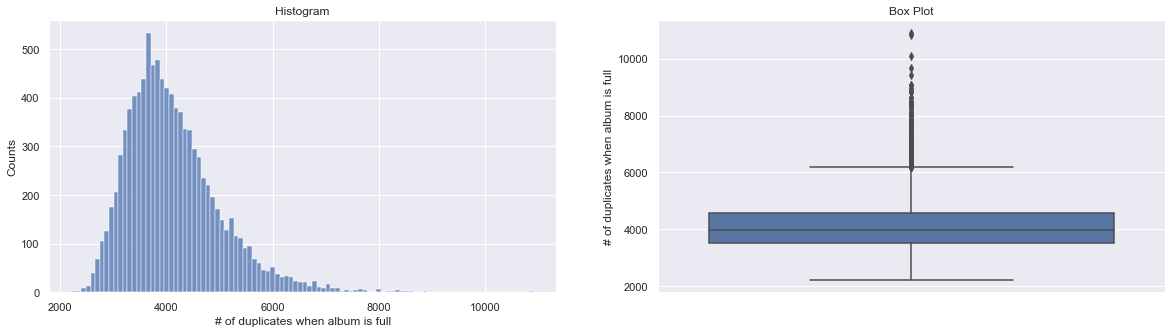

In [162]:
fig, axes = plt.subplots(1, 2, figsize=(20,5));
sns.histplot(ax=axes[0], x=amount_of_duplicates,  bins='sqrt');
axes[0].set(ylabel='Counts', xlabel='# of duplicates when album is full');
axes[0].set_title('Histogram')
#sns.violinplot(ax=axes[1], y=amount_of_duplicates);
#axes[1].set_title('Violin Plot')
#axes[1].set(ylabel='# of duplicates when album is full');
sns.boxplot(ax=axes[1], y=amount_of_duplicates);
axes[1].set_title('Box Plot')
axes[1].set(ylabel='# of duplicates when album is full');
fig.savefig('img/no_swapping/no_of_duplicates')